# <span style="color:black"> Numerical Simulation Laboratory (NSL) </span>

## Francesco Gnan - <span style="color:grey">  Numerical Exercises 7</span>
------------------------------------------------------------------------------------------------------------------------------

# <span style="color:red"> Introduction </span>

In this exercise we want to extend the code <font face = "Courier"> `MD_MC.cpp` </font> used in *Exercise 4*. Specifically, by setting in the input files <font face = "Courier"> `iNVET = 1` </font>, the code no longer solves the equations of motion of each particle using Verlet's algorithm, but exploits the **Metropolis algorithm** by adopting the statistical mechanics approach.

  - Since in *Exercise 4* we used a potential with a spherical cutoff at a distance $r_c$, in *Exercise 07.1* we introduce **tail corrections**, to compensate for the missing long-range part of the potential
  - After an **equilibration** phase (requested by the Metropolis' approach), in *Exercise 07.2* we will print out instantaneous values of potential energy per particle $U/N$ to investigate the **autocorrelation functions** and **statistical uncertainties** of the expectation value of $𝑈/𝑁$, to estimate how large the blocks in your simulations should be
  - In *Exercise 07.3* we will calculate the **radial distribution function**, $g(r)$, as a function of the radial distance $r$ among particles, with $r \in \left[ 0; L/2\right]$
  - Finally, in *Exercise 07.4* we will perform **Monte Carlo NVT simulations** via a Lennard-Jones model</span> of Argon ($\sigma = 0.34$ nm, $\epsilon/k_B = 120$ K, $m=39.948$ amu) in the following conditions:
1. solid phase: $\rho^\star = 1.1$, $T^\star = 0.8$ (cut-off radius: $r_c = 2.2$)
2. liquid phase: $\rho^\star = 0.8$, $T^\star = 1.1$ (cut-off radius: $r_c = 2.5$)
3. gas phase: $\rho^\star = 0.05$, $T^\star = 1.2$ (cut-off radius: $r_c = 5.0$)

and we will compare these results with those obtained with **Molecular Dynamics NVE simulations** in similar thermodynamic conditions, to prove that statistical physics works.

Below there is a list of the packages that will be used during this notebook:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image

# <span style="color:red"> Exercise 07.1 </span>

We introduce the calculation of tail corrections for potential energy, $U$, and pressure $P$ in function <font face = "Courier"> `Input(void)` </font>; then we add these numbers to the instantaneous values of potential energy and pressure in function <font face = "Courier"> `Averages(int)` </font>.

$$\left<V\right>_{tail} = 8\pi\rho^* \left(\frac{1}{9r_c^9} - \frac{1}{3r_c^3}\right) \qquad \qquad \left<P\right>_{tail} = 32\pi\rho^* \left(\frac{1}{9r_c^9} - \frac{1}{6r_c^3}\right)$$

# <span style="color:red"> Exercise 07.2 </span>

## <span style="color:red"> Equilibration </span>

We first equilibrate our Monte Carlo simulations in the three thermodynamic conditions: solid, liquid, gas. We divide the simulations into $N=5\times 10^5$ blocks, each of one MC step, in order to print out instantaneous values.

For the acceptance rate of the Metropolis to be about $50\%$, we carefully choose the value of the $\delta$ parameter, which is used to propose new particle positions, as can be seen in the <font face = "Courier"> `Move()` </font> function.

  - Solid: $\delta = 0.12$
  - Liquid: $\delta = 0.2$
  
A $\delta$ that is too small implies that the particle moves only a little from its starting position; therefore, the acceptance probability of the MC move will be **maximum**. Too large a $\delta$, on the other hand, implies a risk of particle overlap and thus an energy disadvantage for the system due to the repulsive part of the potential, thus a **zero** acceptance rate.

As far as gas is concerned, since the side of the box where we simulate the system with **Pbc** is

$$L = V^{1/3} = \left(\frac{N}{\rho}\right)^{1/3}$$,

$\delta$ cannot be greater than $L/2 \approx 6.46$ if we want to comply with Pbc. So, to ensure a rate of about $50\%-70\%$, we choose:
  - Gas: $\delta = 6.0$

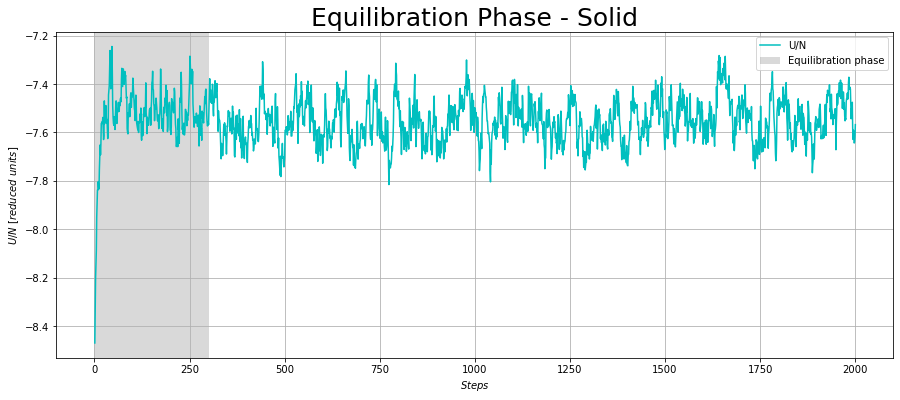

Last U/N value: -7.44159


In [49]:
x1, u1 = np.loadtxt("./Risultati/Solid/Equi_epot.dat", usecols=(0,1), unpack='true')
x2, u2 = np.loadtxt("./Risultati/Liquid/Equi_epot.dat",usecols=(0,1), unpack='true')
x3, u3 = np.loadtxt("./Risultati/Gas/Equi_epot.dat",usecols=(0,1), unpack='true')

plt.figure(figsize=(15,6))
plt.title("Equilibration Phase - Solid", fontsize=25)

plt.plot(x1[:2000],u1[:2000],color='c', label = 'U/N')
plt.xlabel('$Steps$')
plt.ylabel('$U/N \,\,[reduced \,\,units]$')
plt.axvspan(0,300, facecolor='black', alpha=0.15, label='Equilibration phase')
plt.legend()
plt.grid(True)
plt.show()

print('Last U/N value: ' +str(u1[-1]))

After about **300 steps**, the system is equilibrated.

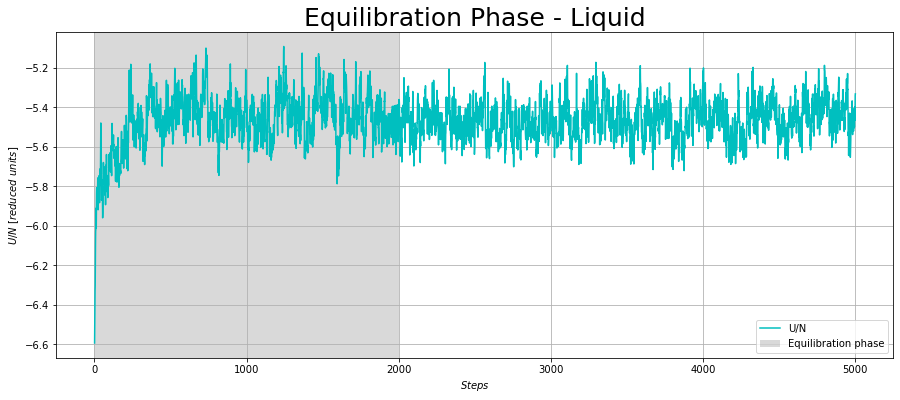

Last U/N value: -5.33198


In [50]:
plt.figure(figsize=(15,6))
plt.title("Equilibration Phase - Liquid", fontsize=25)

plt.plot(x2,u2,color='c', label = 'U/N')
plt.xlabel('$Steps$')
plt.ylabel('$U/N \,\,[reduced\,\, units]$')
plt.axvspan(0,2000, facecolor='black', alpha=0.15, label='Equilibration phase')
plt.legend()
plt.grid(True)
plt.show()

print('Last U/N value: ' +str(u2[-1]))

After about **2000 steps**, the system is equilibrated.

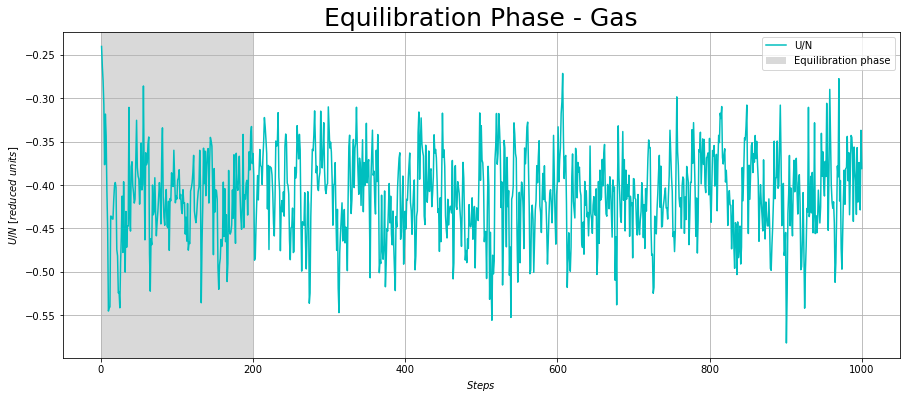

Last U/N value: -0.380975


In [51]:
plt.figure(figsize=(15,6))
plt.title("Equilibration Phase - Gas", fontsize=25)

plt.plot(x3[:1000],u3[:1000],color='c', label = 'U/N')
plt.xlabel('$Steps$')
plt.ylabel('$U/N \,\,[reduced \,\,units]$')
plt.axvspan(0,200, facecolor='black', alpha=0.15, label='Equilibration phase')
plt.legend()
plt.grid(True)
plt.show()

print('Last U/N value: ' +str(u3[-1]))

After about **200 steps**, the system is equilibrated.

## <span style="color:red"> Measures </span>

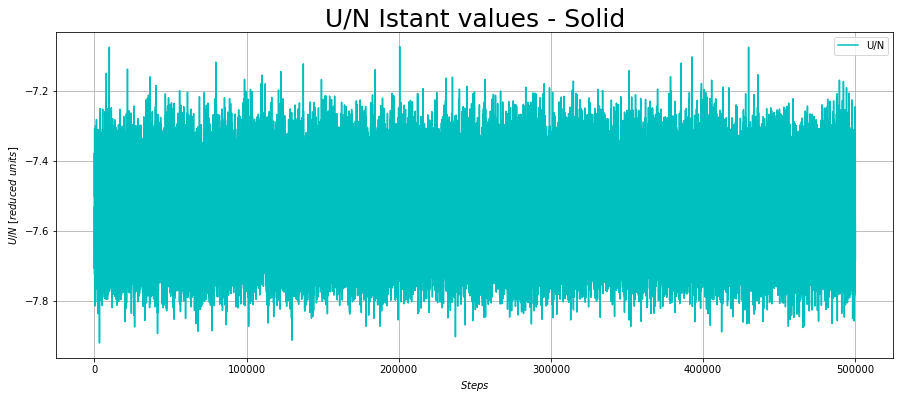

In [52]:
step1, value1 = np.loadtxt("./Risultati/Solid/es2_epot.dat", usecols=(0,1), unpack='true')

plt.figure(figsize=(15,6))
plt.title("U/N Istant values - Solid", fontsize=25)

plt.plot(step1,value1,color='c', label = 'U/N')
plt.xlabel('$Steps$')
plt.ylabel('$U/N\,\, [reduced \,\,units]$')
plt.legend()
plt.grid(True)
plt.show()

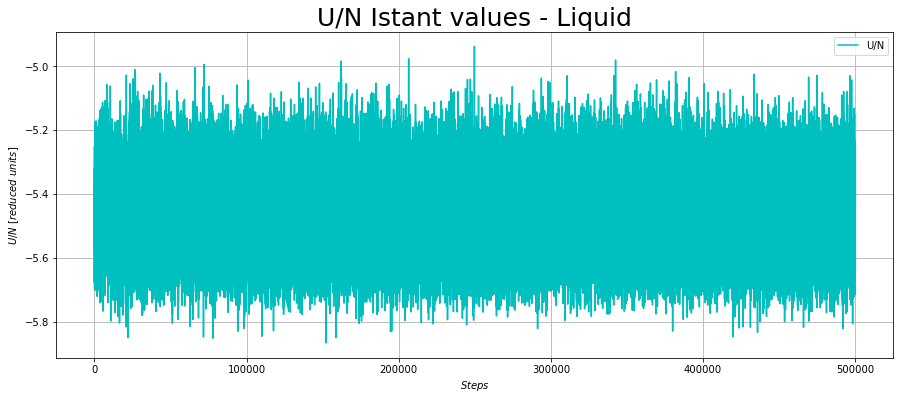

In [53]:
step2, value2 = np.loadtxt("./Risultati/Liquid/es2_epot.dat", usecols=(0,1), unpack='true')

plt.figure(figsize=(15,6))
plt.title("U/N Istant values - Liquid", fontsize=25)

plt.plot(step2,value2,color='c', label = 'U/N')
plt.xlabel('$Steps$')
plt.ylabel('$U/N \,\,[reduced\,\, units]$')
plt.legend()
plt.grid(True)
plt.show()

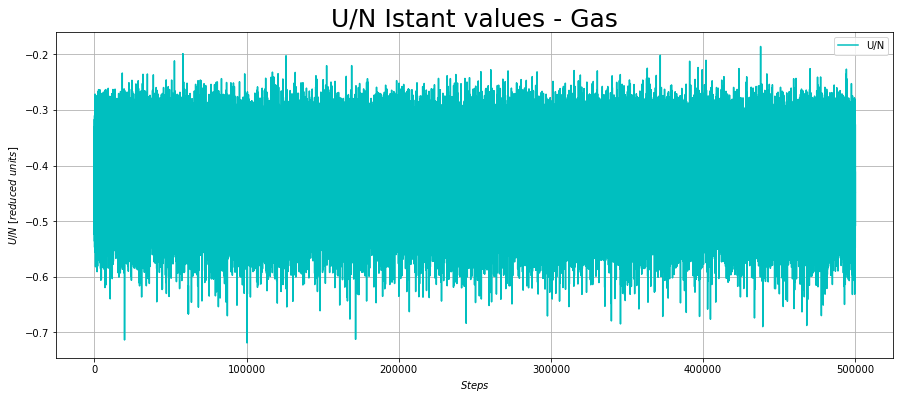

In [54]:
step3, value3 = np.loadtxt("./Risultati/Gas/es2_epot.dat", usecols=(0,1), unpack='true')

plt.figure(figsize=(15,6))
plt.title("U/N Istant values - Gas", fontsize=25)

plt.plot(step3,value3,color='c', label = 'U/N')
plt.xlabel('$Steps$')
plt.ylabel('$U/N\,\, [reduced \,\,units]$')
plt.legend()
plt.grid(True)
plt.show()

## <span style="color:red"> Autocorrelation functions calculation </span>

We wonder what is the optimal **minimum size** for a block.


We calculate the autocorrelation function by applying the following formula:

$$\chi(t) = \frac{\frac{1}{t_{max}-t}\sum_{t'=0}^{t_{max}-t}m(t')m(t'+t) - \frac{1}{t_{max}-t}\sum_{t'=0}^{t_{max}-t}m(t')\times \frac{1}{t_{max}-t}\sum_{t'=0}^{t_{max}-t}m(t'+t)}{\frac{1}{t_{max}} \sum_{t'=0}^{t_{max}}m^2(t') - \left(\frac{1}{t_{max}} \sum_{t'=0}^{t_{max}}m(t')\right)^2 }$$

$t$ is the interval between two consecutive measurements expressed in Monte Carlo steps. $\chi(t)$ takes maximum value $1$ when $t=0$ and tends to zero as $t$ increases, as two measures become less and less correlated.

Plotting graphs of $\chi(t)$ in the different cases, we can give an estimate of the simulation correlation MC-time $t_c$. The correlation time is a measure of how long it takes the system to get from one state to another one which is significantly different from the first. In other words, the correlation time is the typical time-scale on which the autocorrelation drops off; the autocorrelation is expected to fall off exponentially at long times thus:

$$\chi(t) \approx e^{-\frac{t}{t_c}}$$

With this definition, we will see in the following graphs that in fact there is still a significant correlation between two samples taken a correlation time apart: at time $t = t_c$ the autocorrelation function, which is a measure of the 
similarity of the two states, is only a factor of $1/e$ down from its maximum value at $t=0$.

Therefore, we assume that we have **statistical independence** after a MC-time of about $2t_c$.

In [63]:
def ACF(x,max_steps):
    sigma  = np.std(x)
    var    = sigma**2
    t_max  = len(x)
    result = np.zeros(max_steps)
    
    for i in range(max_steps):
        sum1=0.0
        sum2=0.0
        sum3=0.0
        tf = t_max-i
        
        for t in range(tf):
            sum1+=x[t]*x[t+i]
            sum2+=x[t]
            sum3+=x[t+i]
        
        result[i]=( sum1/tf - sum2*sum3 / (tf**2) ) / var
        
    return result

In [71]:
%%time

tmax=1000
solid_ACF = ACF(value1,1000)
liquid_ACF = ACF(value2,1000)
gas_ACF = ACF(value3,1000)

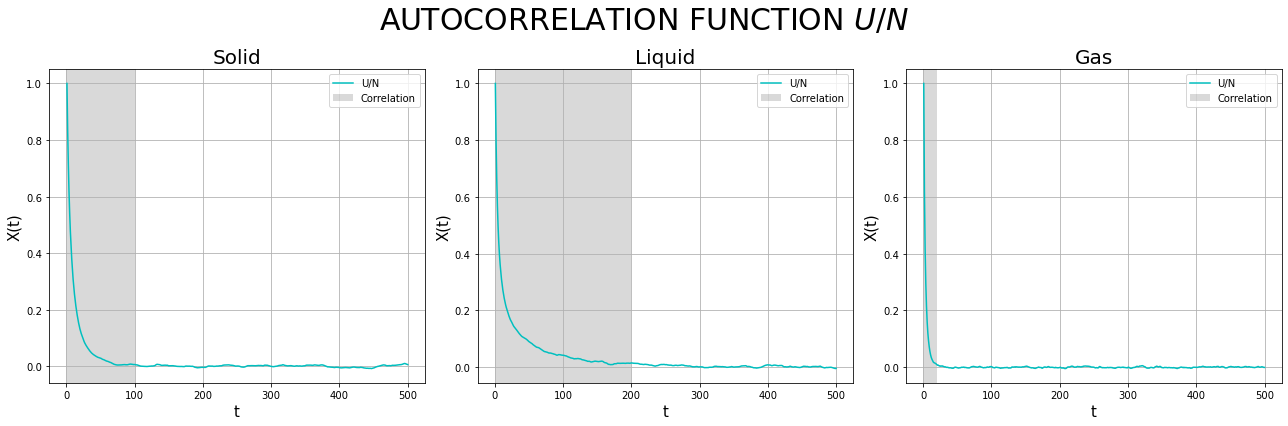

In [110]:
x=np.linspace(1,tmax,tmax)
title = np.array(['Solid','Liquid','Gas'])
plt.figure(figsize=(18,6))
plt.suptitle('AUTOCORRELATION FUNCTION $U/N$',fontsize=30)

for i in range(3):
    plt.subplot(1,3,i+1)
    plt.title(title[i],fontsize=20)
    if(i==0):
        plt.plot(x[:500],solid_ACF[:500],color='c',label='U/N')
        plt.axvspan(0,100, facecolor='black', alpha=0.15, label='Correlation')
    elif(i==1):
        plt.plot(x[:500],liquid_ACF[:500],color='c',label='U/N')
        plt.axvspan(0,200, facecolor='black', alpha=0.15, label='Correlation')
    elif(i==2):
        plt.plot(x[:500],gas_ACF[:500],color='c',label='U/N')
        plt.axvspan(0,20, facecolor='black', alpha=0.15, label='Correlation')    
    plt.xlabel(r't', fontsize=15)    
    plt.ylabel(r'X(t)', fontsize=15)    
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

- As for the solid state, we need to build blocks of at least **200 MC steps**.
- For the liquid, we need minimum **400 MC steps**
- In the case of gas, **40 MC steps** are enough

## <span style="color:red"> Statistical uncertainties </span>

We now ask what is the optimal **maximum size** for a block. If the block were too large, we would be spending computational time without gaining accuracy.

We calculate statistical uncertainties of the expectation value of $𝑈/𝑁$ for different size of the blocks, from $𝐿=𝑀/𝑁=10$ to  $𝐿=5\cdot 10^3$ , being  $𝑁$  the number of blocks and $M$ the number of steps in ech block.

To do this, we apply the data blocking method as it has already been implemented in *Exercise 1*.

For each block size $L$, we graph the last progressive uncertainty calculated with the following <font face = "Courier"> `data_blocking` </font> function.

In [73]:
""" This commented code takes a long time to compile:

def error(AV,AV2,n):  
    if n==0:
        return 0
    else:
        return np.sqrt((AV2[n] - AV[n]**2)/n)

def data_blocking(r,L):   
    
    M = len(r)
    N=int(M/L)
    x = np.arange(N)
    ave = np.zeros(N)
    av2 = np.zeros(N)
    sum_prog = np.zeros(N)
    su2_prog = np.zeros(N)
    err_prog = np.zeros(N)

    for i in range(N):
        sum = 0
        for j in range(L):
            k = j+i*L
            sum += r[k]
        ave[i] = sum/L       
        av2[i] = (ave[i])**2 

    for i in range(N):
        for j in range(i+1):
            sum_prog[i] += ave[j] 
            su2_prog[i] += av2[j] 
        sum_prog[i]/=(i+1) 
        su2_prog[i]/=(i+1) 
        err_prog[i] = error(sum_prog,su2_prog,i) 
        
    return err_prog[len(err_prog)-1]  #I take the uncertainty on the last measurement
"""

In [ ]:
"""
%%time

L = np.arange(10, 5000, 10)
num = len(L)
solid_err  = []
liquid_err = []
gas_err    = []

for i in range(num):
    solid_err.append( data_blocking(value1,L[i]) )
    liquid_err.append( data_blocking(value2,L[i]) )
    gas_err.append( data_blocking(value3,L[i]) )

"""

In [98]:
def error(r,N):
    M = len(r)
    L = int(M/N)
    ave = np.zeros(N)
    
    for i in range(N):
        for j in range(L): 
            ave[i] += r[j+i*L] 
        ave[i] = ave[i]/L
    err = np.sqrt(np.var(ave)/N)
    
    return err

In [102]:
%%time
M = len(step1)
L = np.arange(10, 5000, 50)
     
solid_err  = np.zeros(len(L))
liquid_err = np.zeros(len(L))
gas_err    = np.zeros(len(L))

for i in range(len(L)):     
    N = int(M/L[i])
    solid_err[i]  = error(value1,N)
    liquid_err[i] = error(value2,N)
    gas_err[i]    = error(value3,N)

Wall time: 2min 8s


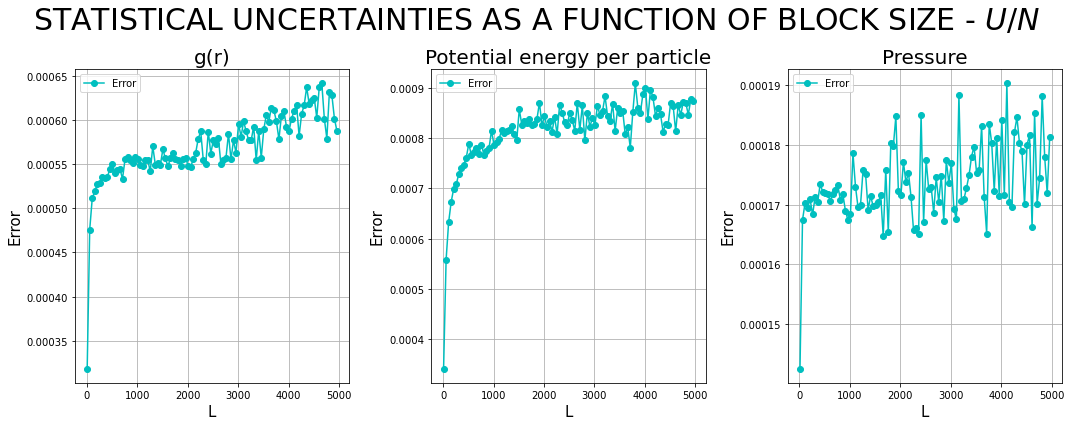

In [155]:
plt.figure(figsize=(15,6))
plt.suptitle('STATISTICAL UNCERTAINTIES AS A FUNCTION OF BLOCK SIZE - $U/N$',fontsize=30)

for i in range(3):
    plt.subplot(1,3,i+1)
    plt.title(title[i],fontsize=20)
    if(i==0):
        plt.plot(L,solid_err,color='c',marker='o',label='Error')
    elif(i==1):
        plt.plot(L,liquid_err,color='c',marker='o',label='Error')
    elif(i==2):
        plt.plot(L,gas_err,color='c',marker='o',label='Error')
    
    plt.xlabel(r'L', fontsize=15)    
    plt.ylabel(r'Error', fontsize=15)    
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

So, the uncertainty changes whether we make smaller blocks or gradually larger blocks with respect to the correlation time .
Smaller blocks provide an underestimate of uncertainty. As they grow we will have an estimate of the error that will saturate around some optimal value. One must be careful, however, that beyond a certain size L, errors begin to fluctuate excessively. 

For these reasons we choose an optimal block size in different cases:

   - Solid:  $L \approx 2000$
   - Liquid: $L \approx 3000$
   - Gas:    $L \approx 1500$

# <span style="color:red"> Exercise 07.3 </span>

We now calculate the **radial distribution function**, $g(r)$, as a function of the radial distance $r$ among particles, with $r \in \left[ 0; \,L/2\right]$. This function gives the probability of finding a pair of atoms a distance $r$ apart, relative to theprobability expected for a completely random distribution at the same density.

$$g(r) = \frac{1}{\rho N \Delta V(r)}\left< \sum \sum_{i\neq j = 1}^N \delta \left[\,\,\left|\vec{r}\right| - \left|\vec{r}_i - \vec{r}_j\right|\,\,\right]\right>$$

where $$\Delta V(r) = \frac{4\pi}{3}\left[\, (r+dr)^3 - r^3 \, \right]$$

So, during the simulation, we fill an histogram by increasing the bin by 2 at $r$ whenever we find two particles at 
distance between $r$ and $r+dr$. At the end of the simulation we normalize the histogram with the quantity $\rho N \Delta V(r)$ as it is done in <font face = "Courier"> `Averages(int)` </font> function.

# <span style="color:red"> Exercise 07.4 </span>

In this exercise we compare the values of $U/N$, $P$ and $g(r)$ obtained by applying the **Monte Carlo approach** of the Metropolis algorithm with the results of **Molecular Dynamics**.

## <span style="color:red"> Solid </span>

In [158]:
MC_r, MC_g, MC_err_g = np.loadtxt("./Risultati/Exercise07.4/MC_solid_g_final.dat", usecols=(0,1,2), unpack='true')
MC_iblk, MC_ene, MC_err_ene = np.loadtxt("./Risultati/Exercise07.4/MC_solid_epot.dat", usecols=(0,2,3), unpack='true')
MC_iblk, MC_pres, MC_err_pres = np.loadtxt("./Risultati/Exercise07.4/MC_solid_press.dat", usecols=(0,2,3), unpack='true')

MD_r, MD_g, MD_err_g = np.loadtxt("./Risultati/Exercise07.4/MD_solid_g_final.dat", usecols=(0,1,2), unpack='true')
MD_iblk, MD_ene, MD_err_ene = np.loadtxt("./Risultati/Exercise07.4/MD_solid_epot.dat", usecols=(0,2,3), unpack='true')
MD_iblk, MD_pres, MD_err_pres = np.loadtxt("./Risultati/Exercise07.4/MD_solid_press.dat", usecols=(0,2,3), unpack='true')

title = np.array(['g(r)','Potential energy per particle','Pressure','Pressure'])

We use 100 blocks of 2000 steps each. For the $g(r)$ we choose 900 bins. Measurements begin after 300 steps of equilibration.

For the MD simulation we started with a temperature $T = 1.5415$, $\delta = 0.0005$ and $300$ equilibration steps, as we have done in *Exercise 4*.

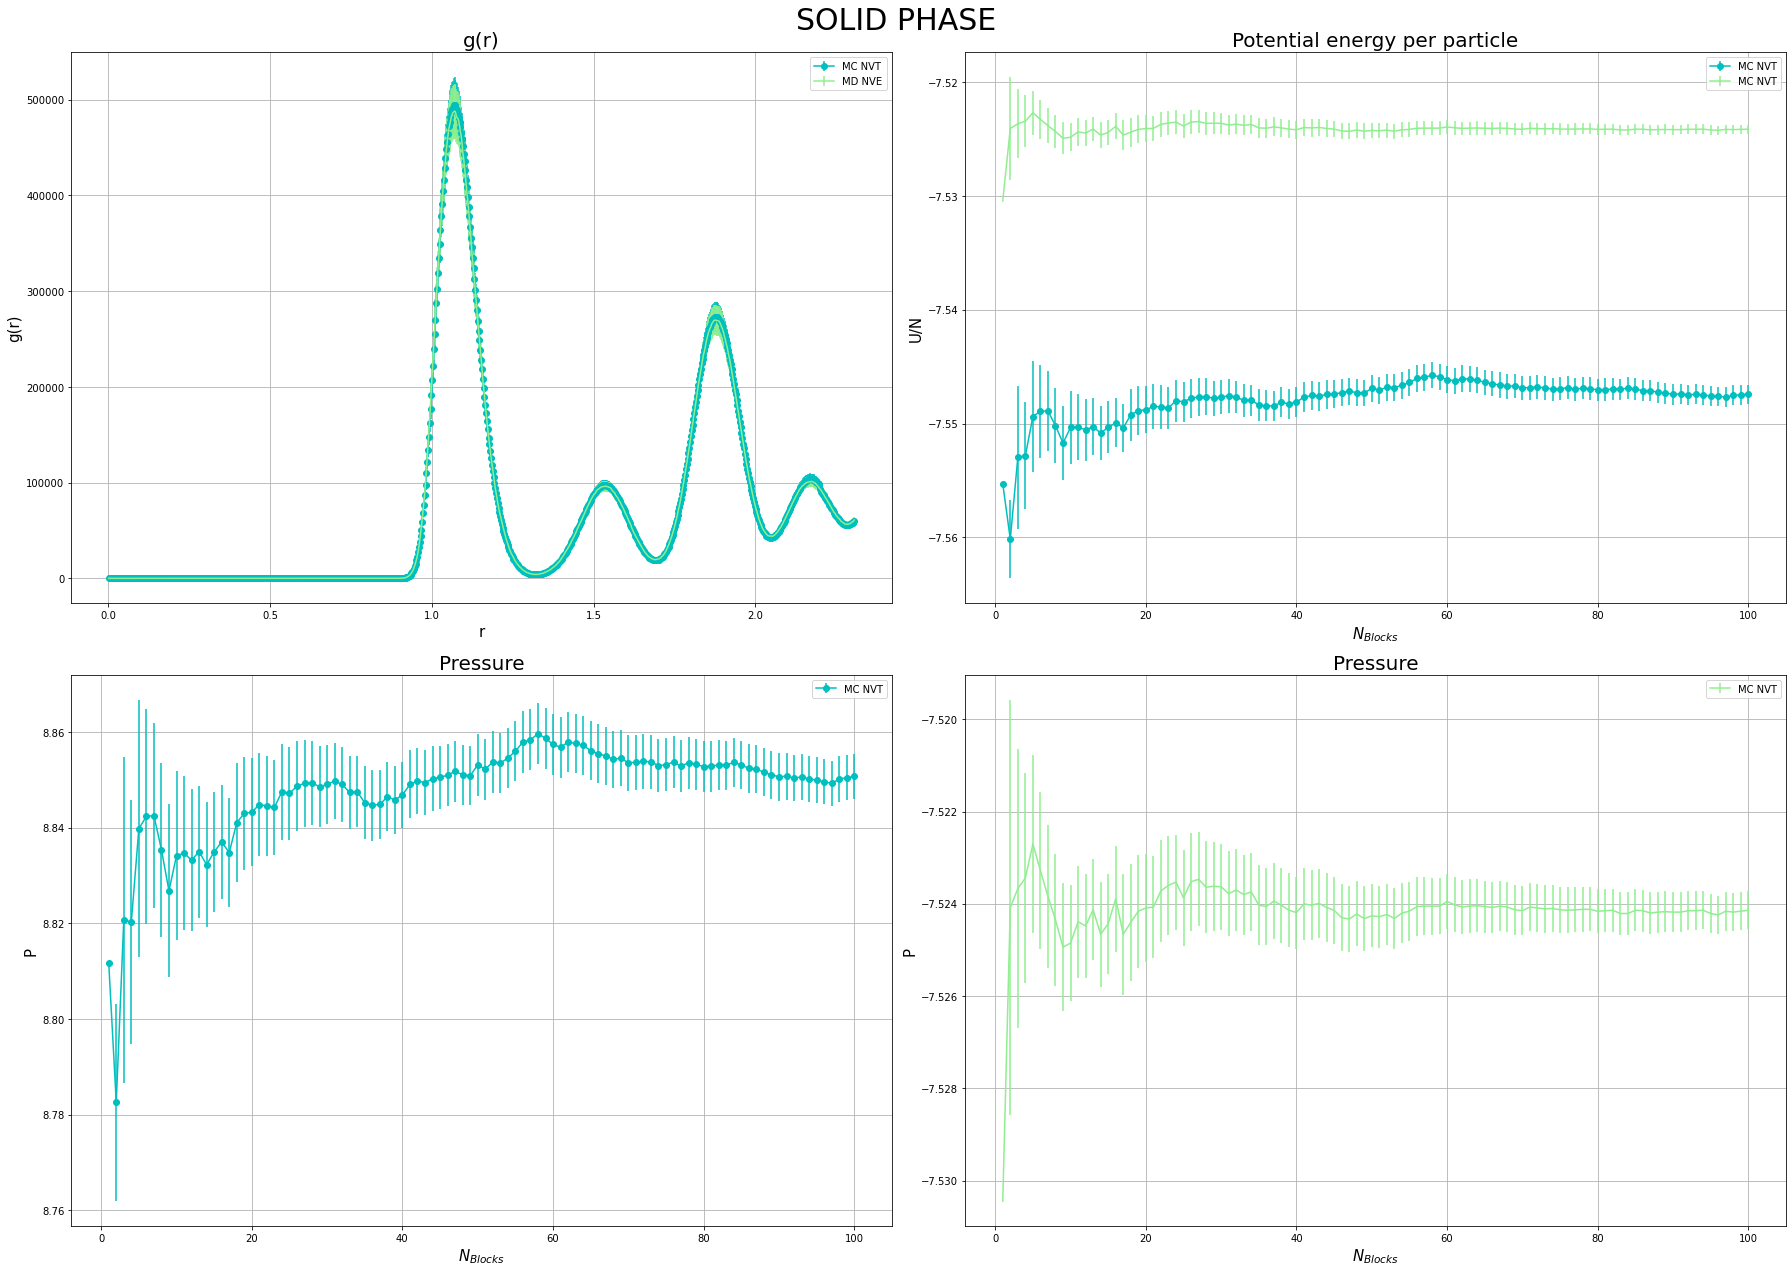

In [159]:
plt.figure(figsize=(25,18))
plt.suptitle('SOLID PHASE',fontsize=30)

for i in range(4):
    plt.subplot(2,2,i+1)
    plt.title(title[i],fontsize=20)
    if(i==0):
        plt.errorbar(MC_r,MC_g,yerr=MC_err_g, color='c', marker='o',label='MC NVT')
        plt.errorbar(MD_r,MD_g,yerr=MD_err_g, color='lightgreen',label='MD NVE')
        plt.xlabel(r'r', fontsize=15)    
        plt.ylabel(r'g(r)', fontsize=15)
    elif(i==1):
        plt.errorbar(MC_iblk,MC_ene,yerr=MC_err_ene, color='c', marker='o',label='MC NVT')
        plt.errorbar(MD_iblk,MD_ene,yerr=MD_err_ene, color='lightgreen',label='MC NVT')
        plt.xlabel(r'$N_{Blocks}$', fontsize=15)    
        plt.ylabel(r'U/N', fontsize=15)
    elif(i==2):
        plt.errorbar(MC_iblk,MC_pres,yerr=MC_err_pres, color='c', marker='o',label='MC NVT')
        plt.xlabel(r'$N_{Blocks}$', fontsize=15)    
        plt.ylabel(r'P', fontsize=15)
    elif(i==3):
        plt.errorbar(MD_iblk,MD_ene,yerr=MD_err_ene, color='lightgreen',label='MC NVT')
        plt.xlabel(r'$N_{Blocks}$', fontsize=15)    
        plt.ylabel(r'P', fontsize=15)
    
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

## <span style="color:red"> Liquid </span>

In [160]:
MC_r, MC_g, MC_err_g = np.loadtxt("./Risultati/Exercise07.4/MC_liquid_g_final.dat", usecols=(0,1,2), unpack='true')
MC_iblk, MC_ene, MC_err_ene = np.loadtxt("./Risultati/Exercise07.4/MC_liquid_epot.dat", usecols=(0,2,3), unpack='true')
MC_iblk, MC_pres, MC_err_pres = np.loadtxt("./Risultati/Exercise07.4/MC_liquid_press.dat", usecols=(0,2,3), unpack='true')

MD_r, MD_g, MD_err_g = np.loadtxt("./Risultati/Exercise07.4/MD_liquid_g_final.dat", usecols=(0,1,2), unpack='true')
MD_iblk, MD_ene, MD_err_ene = np.loadtxt("./Risultati/Exercise07.4/MD_liquid_epot.dat", usecols=(0,2,3), unpack='true')
MD_iblk, MD_pres, MD_err_pres = np.loadtxt("./Risultati/Exercise07.4/MD_liquid_press.dat", usecols=(0,2,3), unpack='true')

title = np.array(['g(r)','Potential energy per particle','Pressure','Pressure'])

We use 100 blocks of 3000 steps each. For the $g(r)$ we choose 900 bins. Measurements begin after 2000 steps of equilibration.

For the MD simulation we started with a temperature $T = 1.984$ and $\delta = 0.0005$, as we have done in *Exercise 4*.

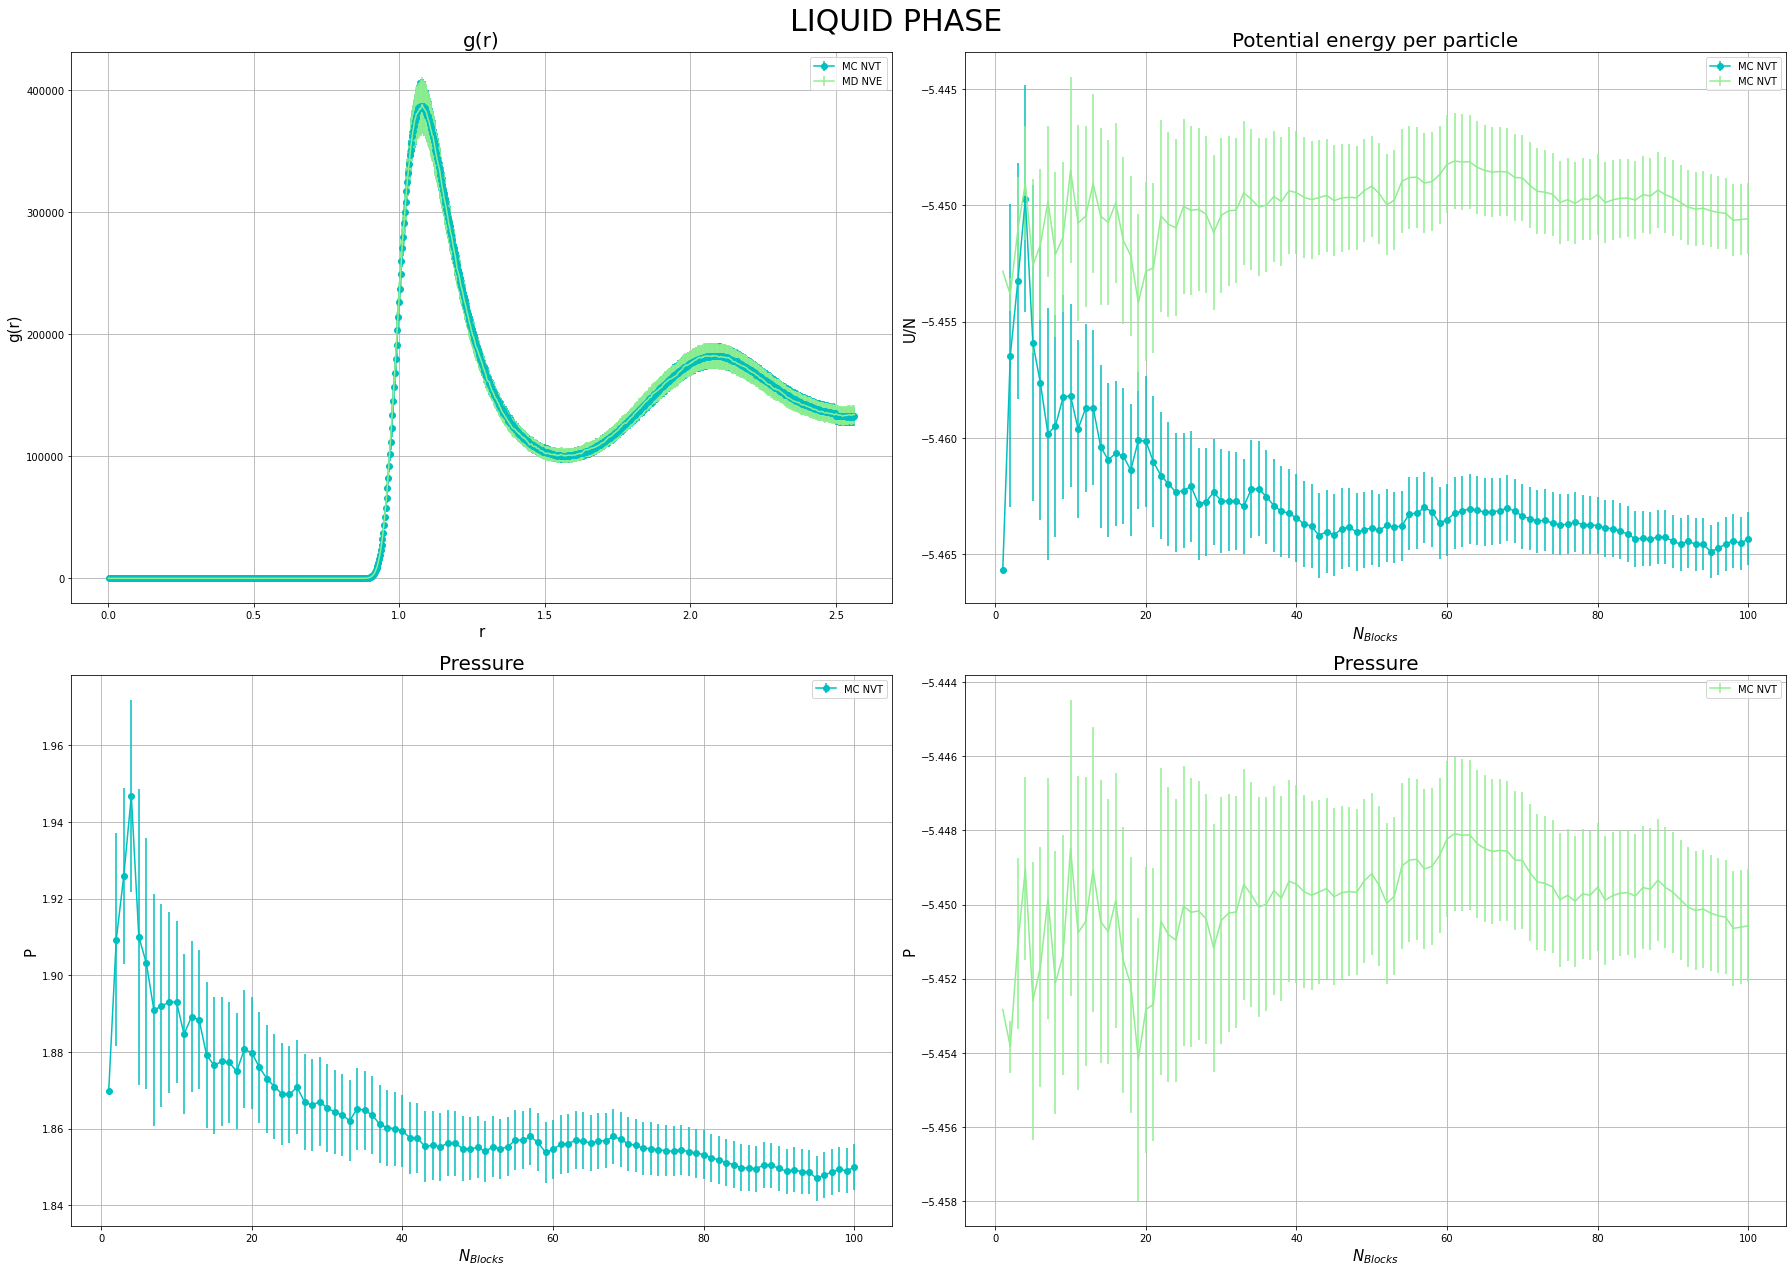

In [161]:
plt.figure(figsize=(25,18))
plt.suptitle('LIQUID PHASE',fontsize=30)

for i in range(4):
    plt.subplot(2,2,i+1)
    plt.title(title[i],fontsize=20)
    if(i==0):
        plt.errorbar(MC_r,MC_g,yerr=MC_err_g, color='c', marker='o',label='MC NVT')
        plt.errorbar(MD_r,MD_g,yerr=MD_err_g, color='lightgreen',label='MD NVE')
        plt.xlabel(r'r', fontsize=15)    
        plt.ylabel(r'g(r)', fontsize=15)
    elif(i==1):
        plt.errorbar(MC_iblk,MC_ene,yerr=MC_err_ene, color='c', marker='o',label='MC NVT')
        plt.errorbar(MD_iblk,MD_ene,yerr=MD_err_ene, color='lightgreen',label='MC NVT')
        plt.xlabel(r'$N_{Blocks}$', fontsize=15)    
        plt.ylabel(r'U/N', fontsize=15)
    elif(i==2):
        plt.errorbar(MC_iblk,MC_pres,yerr=MC_err_pres, color='c', marker='o',label='MC NVT')
        plt.xlabel(r'$N_{Blocks}$', fontsize=15)    
        plt.ylabel(r'P', fontsize=15)
    elif(i==3):
        plt.errorbar(MD_iblk,MD_ene,yerr=MD_err_ene, color='lightgreen',label='MC NVT')
        plt.xlabel(r'$N_{Blocks}$', fontsize=15)    
        plt.ylabel(r'P', fontsize=15)
    
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

## <span style="color:red"> Gas </span>

In [8]:
MC_r, MC_g, MC_err_g = np.loadtxt("./Risultati/Exercise07.4/MC_gas_g_final.dat", usecols=(0,1,2), unpack='true')
MC_iblk, MC_ene, MC_err_ene = np.loadtxt("./Risultati/Exercise07.4/MC_gas_epot.dat", usecols=(0,2,3), unpack='true')
MC_iblk, MC_pres, MC_err_pres = np.loadtxt("./Risultati/Exercise07.4/MC_gas_press.dat", usecols=(0,2,3), unpack='true')

MD_r, MD_g, MD_err_g = np.loadtxt("./Risultati/Exercise07.4/MD_gas_g_final.dat", usecols=(0,1,2), unpack='true')
MD_iblk, MD_ene, MD_err_ene = np.loadtxt("./Risultati/Exercise07.4/MD_gas_epot.dat", usecols=(0,2,3), unpack='true')
MD_iblk, MD_pres, MD_err_pres = np.loadtxt("./Risultati/Exercise07.4/MD_gas_press.dat", usecols=(0,2,3), unpack='true')

title = np.array(['g(r)','Potential energy per particle','Potential energy per particle','Pressure','Pressure'])

- For the MC simulation We use $100$ blocks of $1500$ steps each. For the $g(r)$ we choose 900 bins. Measurements begin after 200 steps of equilibration.

- For the MD simulation we started with a temperature $T = 0.947$, $\delta = 0.0005$, $75000$ steps of equilibration, $20$ blocks of $6250$ steps each, as we have done in *Exercise 4*.

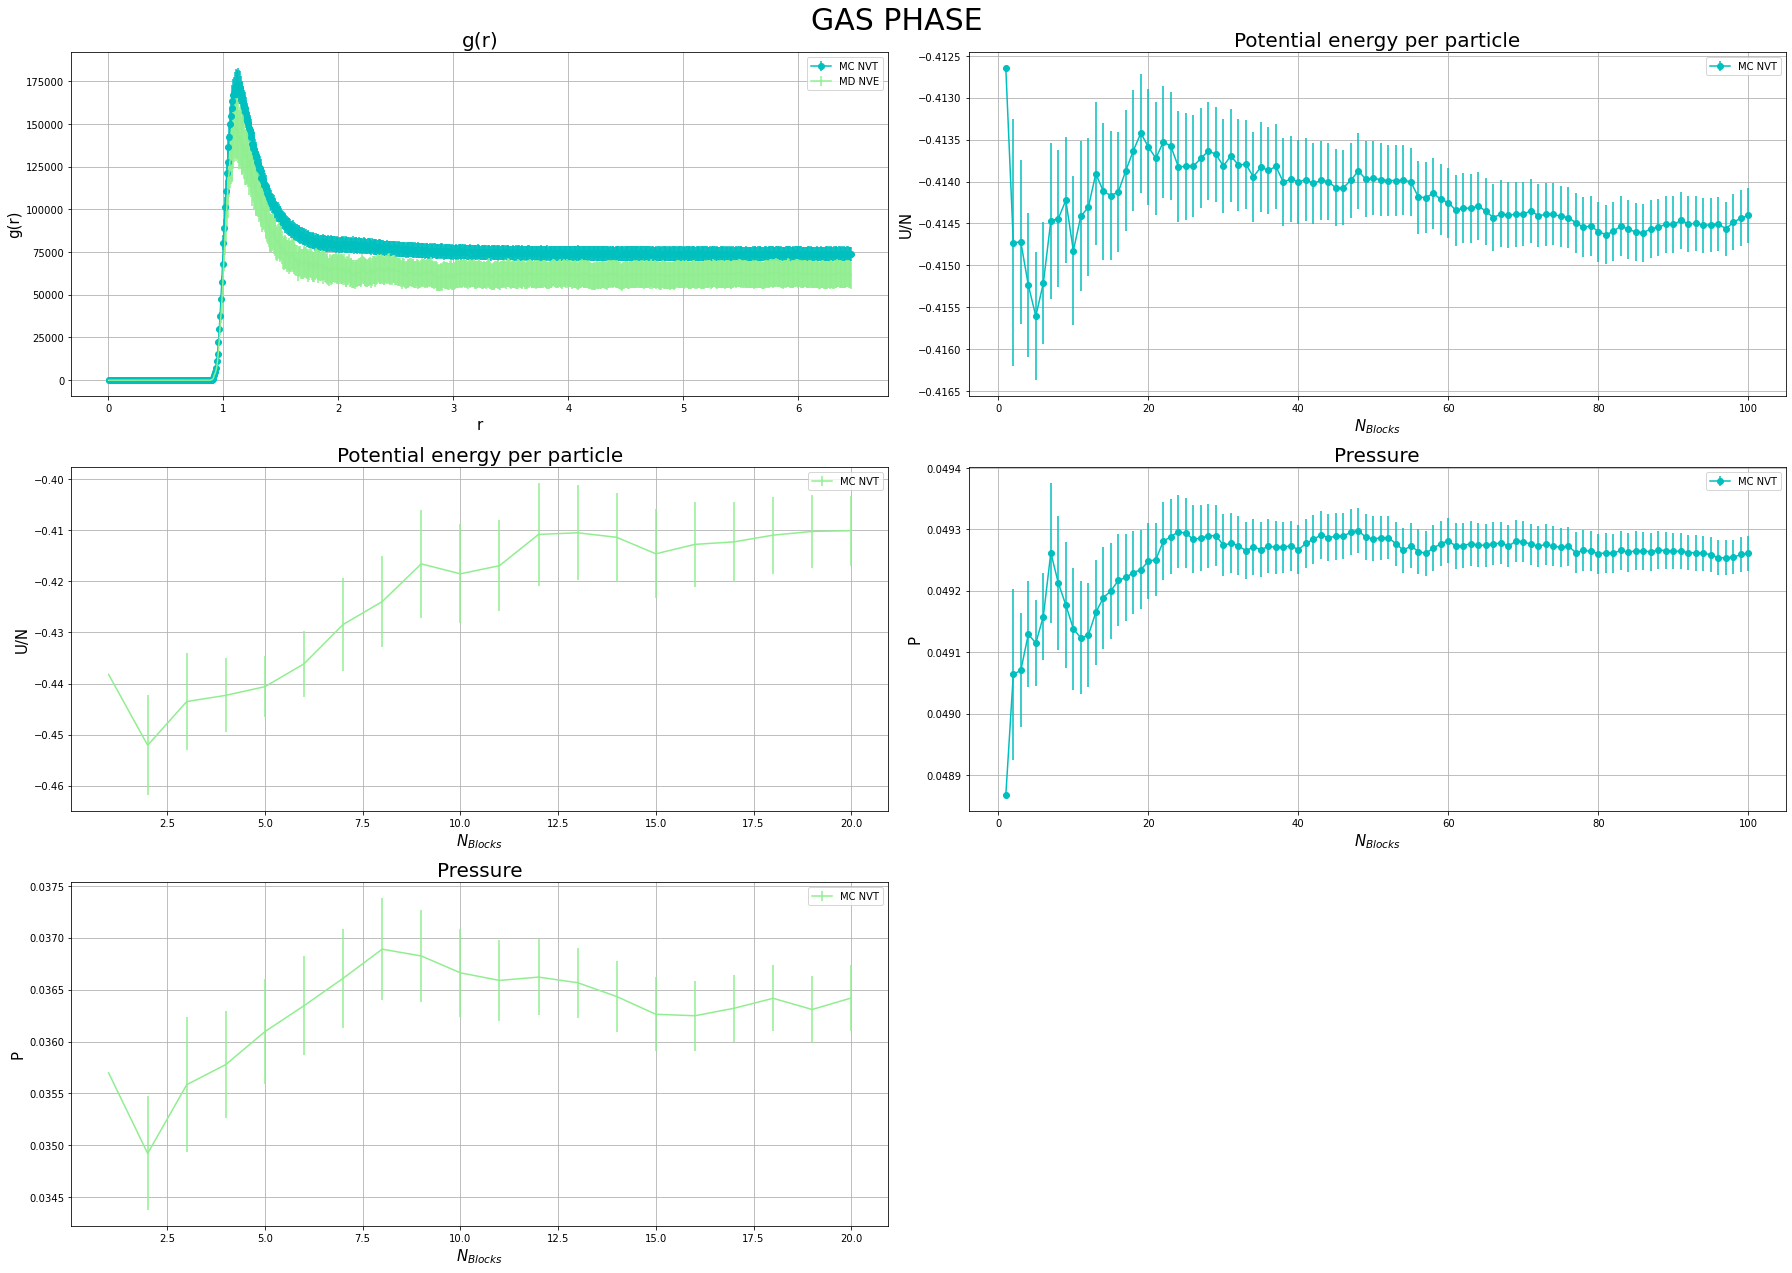

In [10]:
plt.figure(figsize=(25,18))
plt.suptitle('GAS PHASE',fontsize=30)

for i in range(5):
    plt.subplot(3,2,i+1)
    plt.title(title[i],fontsize=20)
    if(i==0):
        plt.errorbar(MC_r,MC_g,yerr=MC_err_g, color='c', marker='o',label='MC NVT')
        plt.errorbar(MD_r,MD_g,yerr=MD_err_g, color='lightgreen',label='MD NVE')
        plt.xlabel(r'r', fontsize=15)    
        plt.ylabel(r'g(r)', fontsize=15)
    elif(i==1):
        plt.errorbar(MC_iblk,MC_ene,yerr=MC_err_ene, color='c', marker='o',label='MC NVT')
        plt.xlabel(r'$N_{Blocks}$', fontsize=15)    
        plt.ylabel(r'U/N', fontsize=15)
    elif(i==2):
        plt.errorbar(MD_iblk,MD_ene,yerr=MD_err_ene, color='lightgreen',label='MC NVT')
        plt.xlabel(r'$N_{Blocks}$', fontsize=15)    
        plt.ylabel(r'U/N', fontsize=15)
    elif(i==3):
        plt.errorbar(MC_iblk,MC_pres,yerr=MC_err_pres, color='c', marker='o',label='MC NVT')
        plt.xlabel(r'$N_{Blocks}$', fontsize=15)    
        plt.ylabel(r'P', fontsize=15)
    elif(i==4):
        plt.errorbar(MD_iblk,MD_pres,yerr=MD_err_pres, color='lightgreen',label='MC NVT')
        plt.xlabel(r'$N_{Blocks}$', fontsize=15)    
        plt.ylabel(r'P', fontsize=15)
    
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

The two approaches, MC and MD, simulate the physical system in totally different ways. Therefore, when we equilibrate the system or we perform measurements, we have to act in different ways, as we did in this exercise.
These differences explain the different results in potential energy and pressure measurements. However, the fact that the $g(r)$ obtained by both methods match allows us to conclude that statistical physics works.